<a href="https://colab.research.google.com/github/Katmalu/hse22_hw1/blob/main/KATMALU_hsebio_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [47]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-11-21 12:24:13--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 165.112.9.228, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M   902KB/s    in 1.3s    

2022-11-21 12:24:17 (902 KB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2022-11-21 12:24:17--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 165.112.9.228, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm

### Reading sequences

In [48]:
!pip install bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [95]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [96]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [97]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [98]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [99]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


### Prediction

In [100]:
import math

def cod_proba(seq, t1, t2, frame=1):
  
  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  prev_nuc = seq[0]
  start_pos = (1 - frame) % 3 + 1
  pos = 'pos' + str(start_pos)
  log_prob = math.log2(t1[pos][seq[0]])

  for i, nuc in enumerate(seq[1:], start = start_pos):
    pos = 'pos' + str(i % 3 + 1) 
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += math.log2(t2[pos][pair])
    prev_nuc = nuc
  return 2**(log_prob)

def ncod_proba(seq, t1, t2):
  
  if len(seq) == 0:
    print('No sequence')
    return None
  
  prev_nuc = seq[0]
  log_prob = math.log2(t1['nc'][seq[0]])

  for nuc in seq[1:]:
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += math.log2(t2['nc'][pair])
    prev_nuc = nuc
  return 2**log_prob

def get_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2, frame=1)
  prob2 = cod_proba(seq, t1, t2, frame=2)
  prob3 = cod_proba(seq, t1, t2, frame=3)
  probnc = ncod_proba(seq, t1, t2)
  sum = prob1 + prob2 + prob3 + probnc
  return [prob1/sum, prob2/sum, prob3/sum, probnc/sum] # мы считаем P(C1) = P(C2) = P(C3) = P(NC) = 0.25 так что они сокращаются

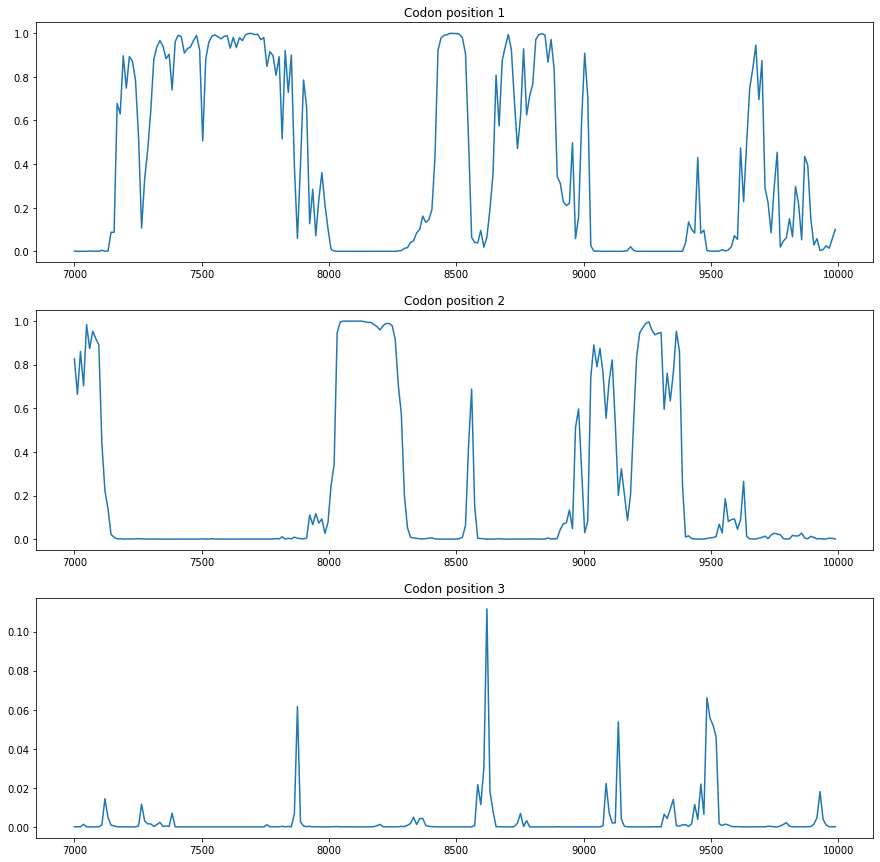

In [101]:
def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

  x = range(start, end, step)
  
  ax1.plot(x,data[:,0])
  ax2.plot(x,data[:,1])
  ax3.plot(x,data[:,2])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()


start = 7000
end = 10000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
    pos_probs.append(get_cod_probs(seq[ i : i + window ], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph(pos_probs, start, end, step)

#БОНУС 1

In [107]:
def find_ORF(seq, start, end, frame=1):

  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  st = frame + start - 1
  starts = []
  stops = []
  ORF = []
  for i in range(st, end, 3):
    if seq[i:i+3] == 'ATC':
      starts.append(i)
    elif seq[i:i+3] in ['TAG','TAA','TGA']:
      stops.append(i)

  for j in range(0, stops[0]):
    if j in starts:
      ORF.append([j,stops[0]]) 
  for i in range(len(stops)):
    for j in range(stops[i-1], stops[i]):
      if j in starts:
        ORF.append([j,stops[i]])

  return [starts, stops, ORF]


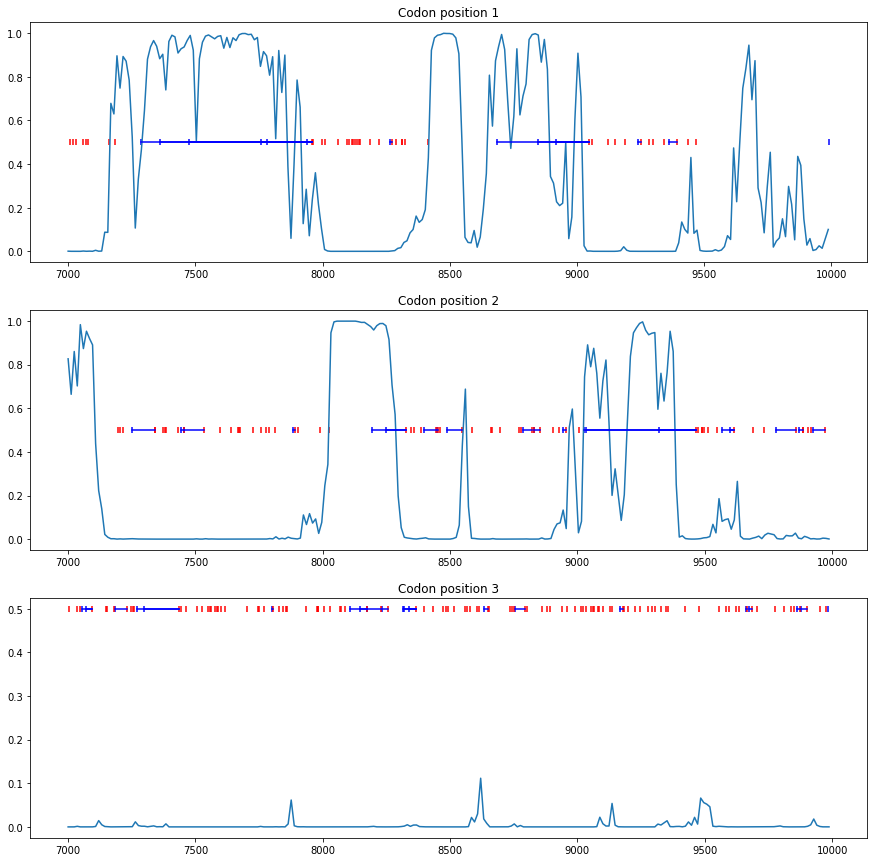

In [121]:
def plot_graph_1(data, seq, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

  x = range(start, end, step)
  
  ax1.plot(x,data[:,0])
  ax2.plot(x,data[:,1])
  ax3.plot(x,data[:,2])

  orf1 = find_ORF(seq, start, end, frame=1)
  orf2 = find_ORF(seq, start, end, frame=2)
  orf3 = find_ORF(seq, start, end, frame=3)

  ax1.scatter(orf1[0], [0.5]*len(orf1[0]), color = 'blue',  marker = '|')
  ax2.scatter(orf2[0], [0.5]*len(orf2[0]), color = 'blue',  marker = '|')
  ax3.scatter(orf3[0], [0.5]*len(orf3[0]), color = 'blue',  marker = '|')
  ax1.scatter(orf1[1], [0.5]*len(orf1[1]), color = 'red',  marker = '|')
  ax2.scatter(orf2[1], [0.5]*len(orf2[1]), color = 'red',  marker = '|')
  ax3.scatter(orf3[1], [0.5]*len(orf3[1]), color = 'red',  marker = '|')

  for i in range(len(orf1[2])):
    ax1.plot(orf1[2][i],[0.5, 0.5], color = 'blue')
  for i in range(len(orf2[2])):
    ax2.plot(orf2[2][i],[0.5, 0.5], color = 'blue')
  for i in range(len(orf3[2])):
    ax3.plot(orf3[2][i],[0.5, 0.5], color = 'blue')

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()


start = 7000
end = 10000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
    pos_probs.append(get_cod_probs(seq[ i : i + window ], t1, t2))
pos_probs = np.array(pos_probs) 

plot_graph_1(pos_probs, seq, start, end, step)

#Бонус 2

In [60]:
from Bio.Seq import Seq


def cod_proba_2(seq, t1, t2, frame=1, strand='+'):

  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  if strand == '+':
    prev_nuc = seq[0]
    start_pos = (1 - frame) % 3 + 1
    pos = 'pos' + str(start_pos)
    log_prob = math.log2(t1[pos][seq[0]])

    for i, nuc in enumerate(seq[1:], start = start_pos):
      pos = 'pos' + str(i % 3 + 1) 
      pair = '{}|{}'.format(nuc, prev_nuc)
      log_prob += math.log2(t2[pos][pair])
      prev_nuc = nuc

    return 2**(log_prob)

  elif strand == '-':
    s = Seq(seq)
    s = s.reverse_complement()
    prev_nuc = s[0]
    start_pos = (1 - frame) % 3 + 1
    pos = 'pos' + str(start_pos)
    log_prob = math.log2(t1[pos][s[0]])

    for i, nuc in enumerate(s[1:], start = start_pos):
      pos = 'pos' + str(i % 3 + 1) 
      pair = '{}|{}'.format(nuc, prev_nuc)
      log_prob += math.log2(t2[pos][pair])
      prev_nuc = nuc
      
    return 2**(log_prob)    

  else:
    print('No such strand')
    return None    


In [61]:
def get_cod_probs_2(seq, t1, t2):
  prob1 = cod_proba_2(seq, t1, t2, frame=1, strand='+')
  prob2 = cod_proba_2(seq, t1, t2, frame=2, strand='+')
  prob3 = cod_proba_2(seq, t1, t2, frame=3, strand='+')
  probneg1 = cod_proba_2(seq, t1, t2, frame=1, strand='-')
  probneg2 = cod_proba_2(seq, t1, t2, frame=2, strand='-')
  probneg3 = cod_proba_2(seq, t1, t2, frame=3, strand='-')
  probnc = ncod_proba(seq, t1, t2)
  sum = prob1 + prob2 + prob3 + probnc + probneg1 + probneg2 + probneg3
  return [prob1/sum, prob2/sum, prob3/sum, probneg1/sum, probneg2/sum, probneg3/sum, probnc/sum]

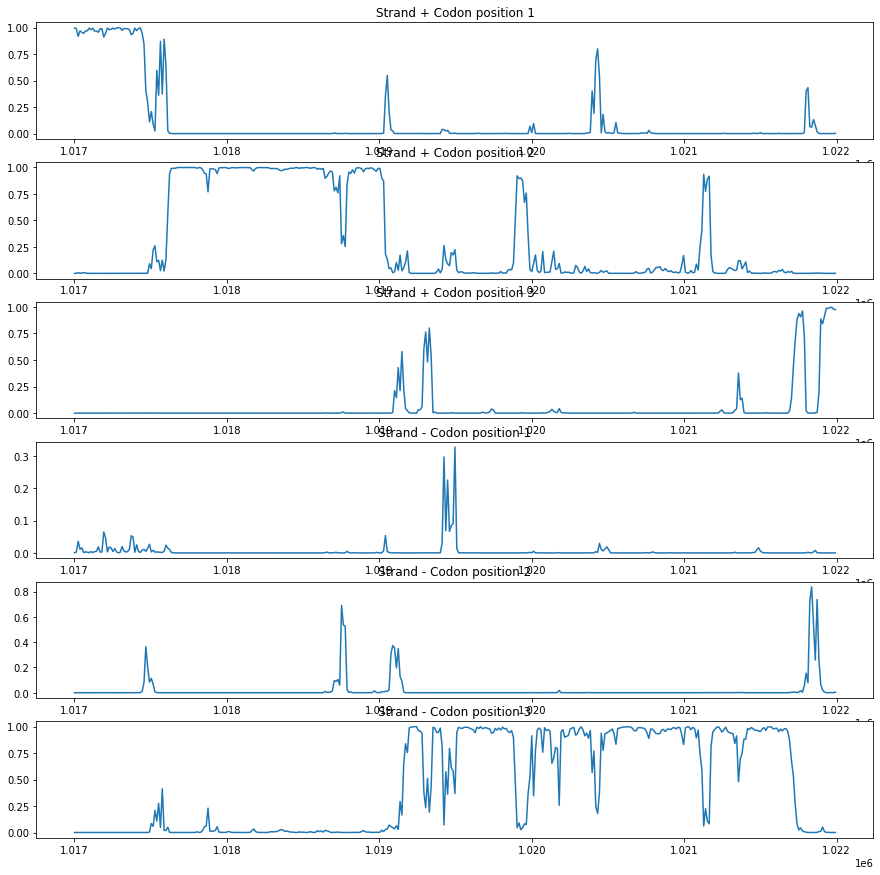

In [62]:
def plot_graph_2(data, start, end, step):
  fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(15, 15))

  x = range(start, end, step)
  
  ax1.plot(x,data[:,0])
  ax2.plot(x,data[:,1])
  ax3.plot(x,data[:,2])
  ax4.plot(x,data[:,3])
  ax5.plot(x,data[:,4])
  ax6.plot(x,data[:,5])

  



  ax1.set_title('Strand + Codon position 1')
  ax2.set_title('Strand + Codon position 2')
  ax3.set_title('Strand + Codon position 3')
  ax4.set_title('Strand - Codon position 1')
  ax5.set_title('Strand - Codon position 2')
  ax6.set_title('Strand - Codon position 3')

  plt.plot()


start = 1017000
end = 1022000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
    pos_probs.append(get_cod_probs_2(seq[ i : i + window ], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph_2(pos_probs, start, end, step)